# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [2]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [3]:
# Install gymnasium if you didn't
!pip install "gymnasium[toy_text,classic_control]"

state vector dim = 4
n_actions = 2


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


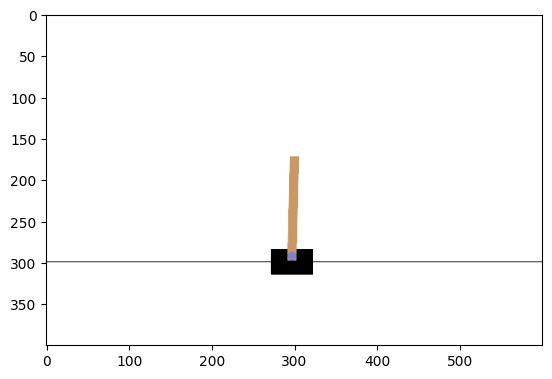

In [5]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [1]:
!nvidia-smi

Tue Jul  1 21:19:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
import os

# Get the number of available CPU cores
num_cores = os.cpu_count()
print(num_cores)

2


In [9]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 596 (delta 128), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (596/596), 195.77 KiB | 1.02 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.13 environment at: /usr
Resolved 173 packages in 1.90s
 Downloaded rmm-cu12
 Downloaded ucx-py-cu12
 Downloaded cudf-cu12
 Downloaded cuproj-cu12
 Downloaded shapely
 Downloaded datashader
 Downloaded dask
 Downloaded libkvikio-cu12
 Downloaded cugraph-cu12
 Downloaded pylibcugraph-cu12
 Downloaded bokeh
 Downloaded cuspatial-cu12
 Downloaded librmm-cu12
 Downloaded cucim-cu12
 Downloaded cuml-cu12
 Downloaded libcuspatial-cu12
 Downloaded pylibcudf-cu12
 Downloaded libraft-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuml-cu12
 Downloaded libcudf-cu12
 Downloaded libcuvs

In [10]:
%load_ext cuml.accel

cuML: Installed accelerator for sklearn.
cuML: Installed accelerator for umap.
cuML: Installed accelerator for hdbscan.
cuML: Successfully initialized accelerator.


In [11]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


[-0.03574613  0.02387939  0.02644337  0.01530154]


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [12]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(s.reshape(1, -1))[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(n_actions, 1, p=probs)[0]
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return (states, actions, total_reward)

In [ ]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[ 4.9365424e-02  3.0850498e-02  3.2756985e-03  4.9105592e-02]
 [ 4.9982432e-02  2.2592533e-01  4.2578103e-03 -2.4254203e-01]
 [ 5.4500941e-02  4.2098621e-01 -5.9303007e-04 -5.3387886e-01]
 [ 6.2920667e-02  6.1611646e-01 -1.1270608e-02 -8.2674861e-01]
 [ 7.5242996e-02  4.2115045e-01 -2.7805580e-02 -5.3763163e-01]]
actions: [np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [13]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)


    elite_states = [s for i, state in enumerate(states_batch) if rewards_batch[i] > reward_threshold for s in state]
    elite_actions = [a for i, action in enumerate(actions_batch) if rewards_batch[i] > reward_threshold for a in action]

    return elite_states, elite_actions


# Training loop
Generate sessions, select N best and fit to those.

In [14]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 968.790, threshold=1000.000


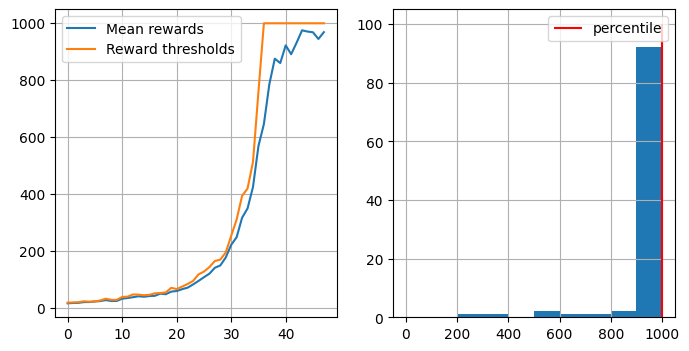

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [ ]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]
    print(len(sessions[0][0]), len(sessions[0][1]), sessions[0][2])

    states_batch, actions_batch, rewards_batch = zip(*sessions) #  map(np.array, zip(*sessions))
    rewards_batch = np.array(rewards_batch)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")


# Results

In [ ]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here>```


1.1
If `percentile` goes down to 30 the algorithm score goes up to a near optimal score of 0 and stays there. If `percentile` goes up to 70 it reaches only score of -100 and then descends at the same rate as does with `percentile` 50.

If `n_sessions` set to 100 then score reaches at max -150 and then slowly goes down. If `n_sessions` set to 500 it reached -150 and stays there.



# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [15]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379376 sha256=368b5e7f530dc8763cde61aa904e704d2a44a099e12f1a45fc0846f2dee3f8ea
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


state vector dim = 2
n_actions = 3


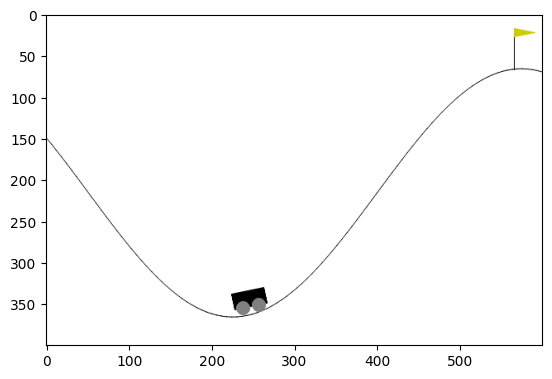

In [16]:
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCar-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [19]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

[-0.4898859  0.       ]


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [17]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    min_position = env.observation_space.low[0]
    max_position = env.observation_space.high[0]
    max_speed = env.observation_space.high[1]
    xs = np.linspace(min_position, max_position, 100)
    vs = np.linspace(-max_speed, max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(min_position, max_position, -max_speed, max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)





/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_arrary' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


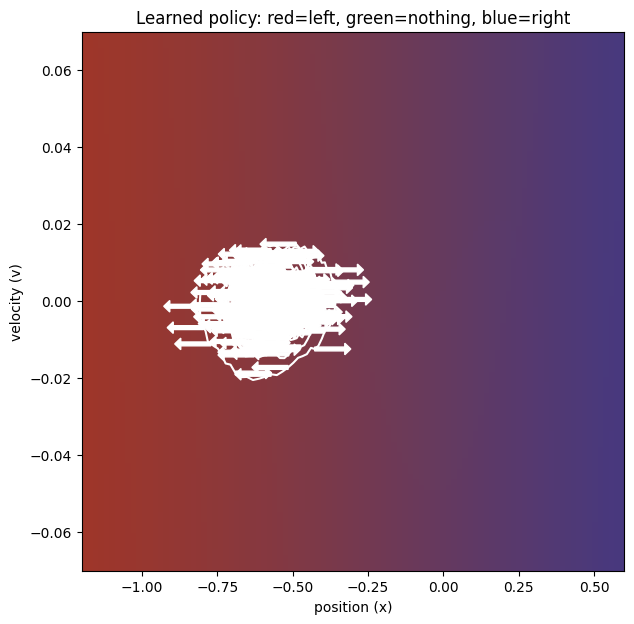

In [20]:
with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)

mean reward = -9052.840, threshold=-5533.400


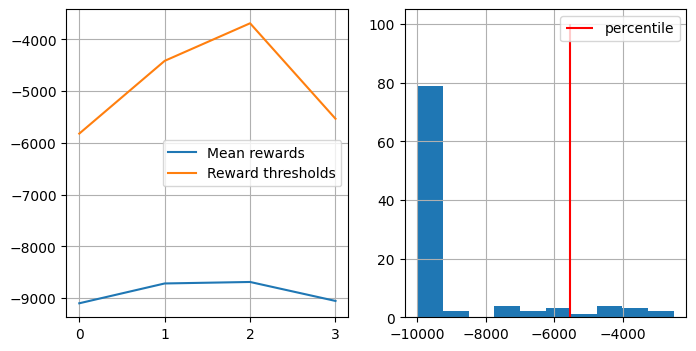

4


KeyboardInterrupt: 

In [ ]:
session_num = 100
percentile = 90
learning_rate = 0.5
log = []

for i in range(10):
  print(i)
  sessions = [generate_session(env, agent, int(1e4)) for j in range(session_num)]
  states_batch, actions_batch, rewards_batch = zip(*sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = -1959.400, threshold=-2350.900


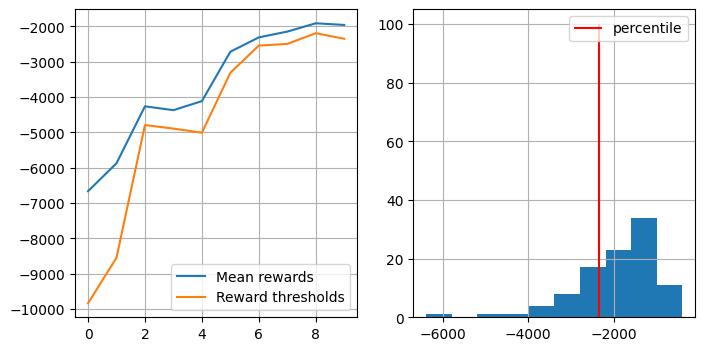

In [ ]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
print("n_actions", n_actions)

session_num = 100
percentile = 30
learning_rate = 0.5
log = []

for i in range(10):
  print(i)
  sessions = [generate_session(env, agent, int(1e4)) for j in range(session_num)]
  states_batch, actions_batch, rewards_batch = zip(*sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  print("len elite_states", len(elite_states))
  if len(elite_states) == 0:
    continue
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = -8043.250, threshold=-10000.000


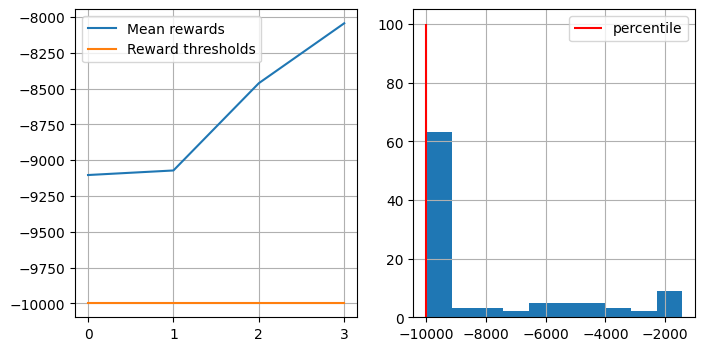

4


KeyboardInterrupt: 

In [ ]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20, 20),
    activation="tanh",
)

print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
print("n_actions", n_actions)

session_num = 100
percentile = 30
learning_rate = 0.5
log = []

for i in range(10):
  print(i)
  sessions = [generate_session(env, agent, int(1e4)) for j in range(session_num)]
  states_batch, actions_batch, rewards_batch = zip(*sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  print("len elite_states", len(elite_states))
  if len(elite_states) == 0:
    continue
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = -1322.720, threshold=-1534.500


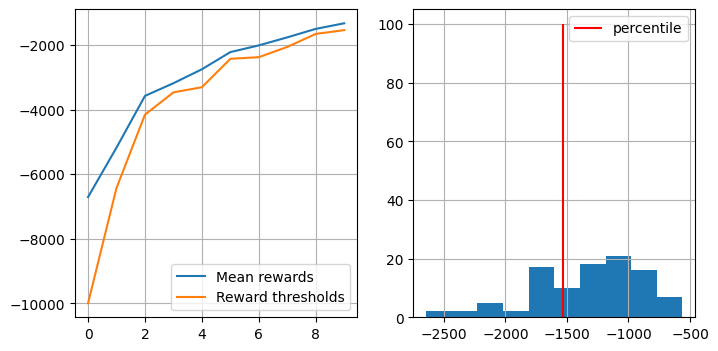

In [ ]:
agent = MLPClassifier(
    hidden_layer_sizes=(100),
    activation="tanh",
)

print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
print("n_actions", n_actions)

session_num = 100
percentile = 30
learning_rate = 0.5
log = []

for i in range(10):
  print(i)
  sessions = [generate_session(env, agent, int(1e4)) for j in range(session_num)]
  states_batch, actions_batch, rewards_batch = zip(*sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  print("len elite_states", len(elite_states))
  if len(elite_states) == 0:
    continue
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = -149.930, threshold=-162.300


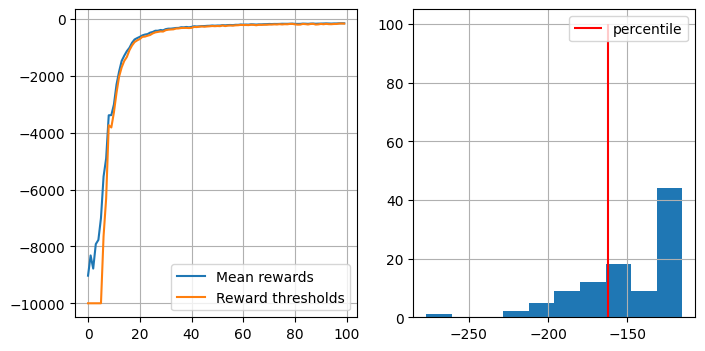

In [ ]:
agent = MLPClassifier(
    hidden_layer_sizes=(100),
    activation="tanh",
)

print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
print("n_actions", n_actions)

session_num = 100
percentile = 30
learning_rate = 0.5
log = []

for i in range(100):
  print(i)
  sessions = [generate_session(env, agent, int(1e4)) for j in range(session_num)]
  states_batch, actions_batch, rewards_batch = zip(*sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  print("len elite_states", len(elite_states))
  if len(elite_states) == 0:
    continue
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = -171.190, threshold=-177.600


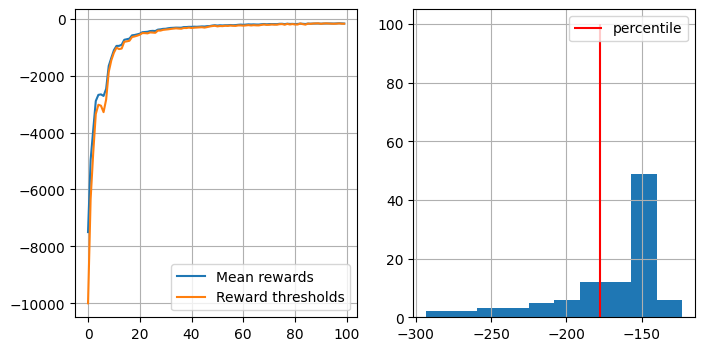

CPU times: user 24min 11s, sys: 1min 31s, total: 25min 42s
Wall time: 25min 8s


In [ ]:
%%time
agent = MLPClassifier(
    hidden_layer_sizes=(100),
    activation="tanh",
)

print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
print("n_actions", n_actions)

session_num = 100
percentile = 30
learning_rate = 0.5
log = []

for i in range(100):
  print(i)
  sessions = [generate_session(env, agent, int(1e4)) for j in range(session_num)]
  states_batch, actions_batch, rewards_batch = zip(*sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  print("len elite_states", len(elite_states))
  if len(elite_states) == 0:
    continue
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

In [21]:
from joblib import Parallel, delayed

mean reward = -177.530, threshold=-190.600


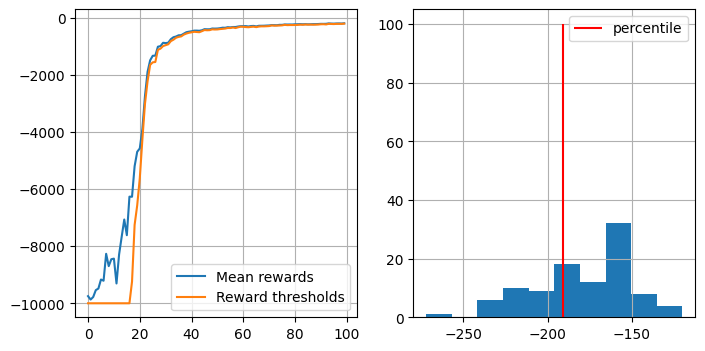

CPU times: user 8min 16s, sys: 12 s, total: 8min 28s
Wall time: 1h 6min 31s


In [ ]:
%%time
import os

# Get the number of available CPU cores
num_cores = os.cpu_count()

print(f"Number of available cores: {num_cores}")

agent = MLPClassifier(
    hidden_layer_sizes=(100),
    activation="tanh",
)

print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
print("n_actions", n_actions)

session_num = 100
percentile = 30
learning_rate = 0.5
log = []
parallelism = num_cores
envs = []
for i in range(parallelism):
  envs.append(gym.make("MountainCar-v0", render_mode="rgb_array").env)

  envs[i].reset()

for i in range(100):
  print(i)

  sessions = Parallel(n_jobs=parallelism)(delayed(generate_session)(env, agent, int(1e4)) for j in range(session_num))
  states_batch, actions_batch, rewards_batch = zip(*sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  print("len elite_states", len(elite_states))
  if len(elite_states) == 0:
    continue
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_arrary' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


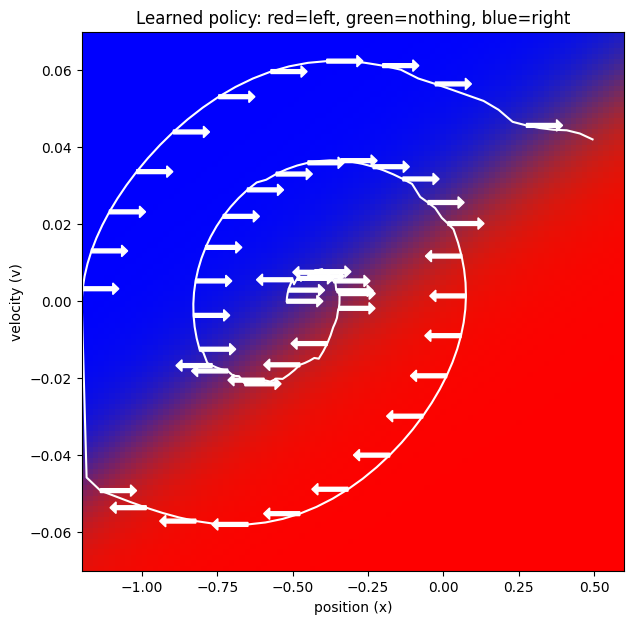

In [ ]:
with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)

mean reward = -132.860, threshold=-128.200


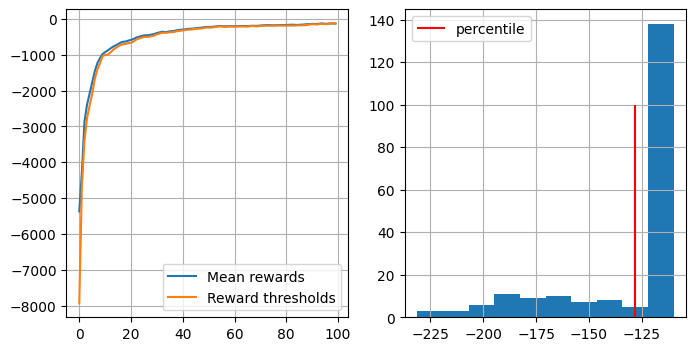

CPU times: user 2min 57s, sys: 3.78 s, total: 3min 1s
Wall time: 16min 58s


In [ ]:
%%time
import os

# Get the number of available CPU cores
num_cores = os.cpu_count()

print(f"Number of available cores: {num_cores}")

agent = MLPClassifier(
    hidden_layer_sizes=(80,20),
    activation="tanh",
)

print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
print("n_actions", n_actions)

session_num = 100
percentile = 30
learning_rate = 0.5
log = []
parallelism = num_cores
envs = []
for i in range(parallelism):
  envs.append(gym.make("MountainCar-v0", render_mode="rgb_array").env)

  envs[i].reset()
cached_sessions = []

for i in range(100):
  print(i)

  sessions = Parallel(n_jobs=parallelism)(delayed(generate_session)(env, agent, int(1e4)) for j in range(session_num))
  cached_sessions.append(sessions)
  if len(cached_sessions) >= 3:
    cached_sessions.pop(0)
  flatten_sessions = [item for sublist in cached_sessions for item in sublist]
  states_batch, actions_batch, rewards_batch = zip(*flatten_sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  print("len elite_states", len(elite_states))
  if len(elite_states) == 0:
    continue
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = -110.865, threshold=-112.000


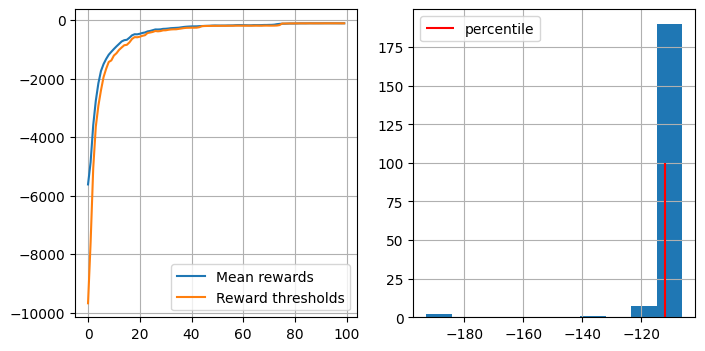

CPU times: user 2min 42s, sys: 3.14 s, total: 2min 46s
Wall time: 15min 55s


In [ ]:
%%time
import os

# Get the number of available CPU cores
num_cores = os.cpu_count()

print(f"Number of available cores: {num_cores}")

agent = MLPClassifier(
    hidden_layer_sizes=(80,20),
    activation="tanh",
)

print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
print("n_actions", n_actions)

session_num = 100
percentile = 20
log = []
parallelism = num_cores
envs = []
for i in range(parallelism):
  envs.append(gym.make("MountainCar-v0", render_mode="rgb_array").env)

  envs[i].reset()
cached_sessions = []

for i in range(100):
  print(i)

  sessions = Parallel(n_jobs=parallelism)(delayed(generate_session)(env, agent, int(1e4)) for j in range(session_num))
  cached_sessions.append(sessions)
  if len(cached_sessions) >= 3:
    cached_sessions.pop(0)
  flatten_sessions = [item for sublist in cached_sessions for item in sublist]
  states_batch, actions_batch, rewards_batch = zip(*flatten_sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  print("len elite_states", len(elite_states))
  if len(elite_states) == 0:
    continue
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = -144.515, threshold=-147.000


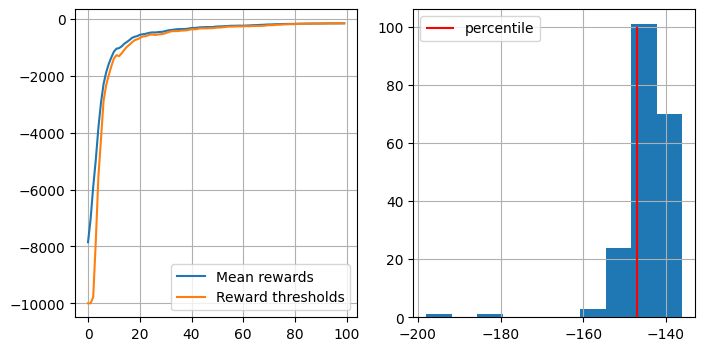

CPU times: user 4min 35s, sys: 8.12 s, total: 4min 43s
Wall time: 30min 16s


In [23]:
%%time
import os

# Get the number of available CPU cores
num_cores = os.cpu_count()

print(f"Number of available cores: {num_cores}")

agent = MLPClassifier(
    hidden_layer_sizes=(70,30),
    activation="tanh",
)

print(env.reset()[0])
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
print("n_actions", n_actions)

session_num = 100
percentile = 20
log = []
parallelism = num_cores
envs = []
for i in range(parallelism):
  envs.append(gym.make("MountainCar-v0", render_mode="rgb_array").env)

  envs[i].reset()
cached_sessions = []

for i in range(100):
  print(i)

  sessions = Parallel(n_jobs=parallelism)(delayed(generate_session)(env, agent, int(1e4)) for j in range(session_num))
  cached_sessions.append(sessions)
  if len(cached_sessions) >= 3:
    cached_sessions.pop(0)
  flatten_sessions = [item for sublist in cached_sessions for item in sublist]
  states_batch, actions_batch, rewards_batch = zip(*flatten_sessions)
  rewards_batch = np.array(rewards_batch)
  elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)
  print("len elite_states", len(elite_states))
  if len(elite_states) == 0:
    continue
  agent.partial_fit(elite_states, elite_actions)

  show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

  # if np.mean(rewards_batch) > 190:
  #     print("You Win! You may stop training now via KeyboardInterrupt.")

In [ ]:
print(num_cores)

2


In [ ]:
from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("MountainCar-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent, int(1e4)) for _ in range(10)]

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.